Given two images, a style image and a content image, produce a in image with the
style from style image and content from content image

In a convolutional neural network, VGG 1 for example, the initial layers depict the style of an input, while the final layers depict the content.

Content loss: new image's content is same as the content image's content.

Style loss: new image's style is same as the style image's style.

In [1]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [2]:
vgg = models.vgg19(pretrained=True).features # features does not give the last layer

#freeze all parameters
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
content = Image.open("dahn.jpg").convert('RGB')
style = Image.open("whitehousenight.jpg").convert("RGB")

In [5]:
transform = transforms.Compose([transforms.Resize((1000,1000)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5),
                                                   (0.5, 0.5, 0.5))])

In [6]:
content = transform(content)[:3,:,:].unsqueeze(0).to(device)
style = transform(style)[:3,:,:].unsqueeze(0).to(device)

In [48]:
def imshow(tensor):
    tensor = tensor.cpu().clone().detach().numpy().squeeze().transpose(1,2,0)
    plt.imshow(np.transpose((tensor / 2) + 0.5, (1, 2, 0)))  # convert from Tensor image

Text(0.5, 1.0, 'Style')

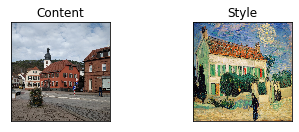

In [8]:
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1, xticks=[], yticks=[])
imshow(content)
ax.set_title('Content')
ax = fig.add_subplot(2, 2, 2, xticks=[], yticks=[])
imshow(style)
ax.set_title('Style')

In [9]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image.to(device)
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

### Gram matrix

In [10]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d,h*w)
    return torch.mm(tensor, tensor.t())

In [11]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [12]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  9856.521484375


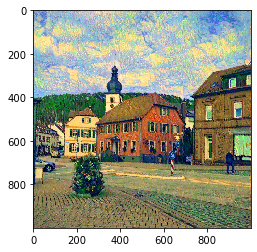

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  8774.453125


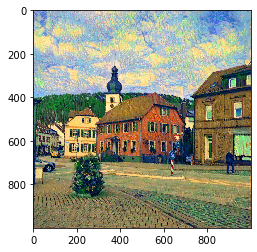

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  8068.97314453125


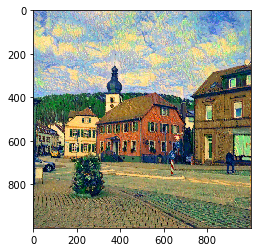

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  7200.65625


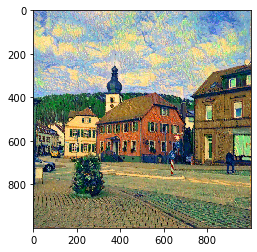

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  6499.8486328125


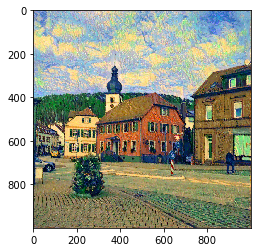

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  6077.7216796875


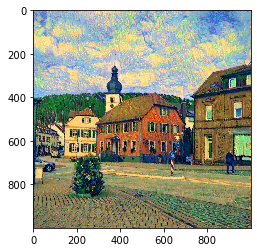

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  6169.35595703125


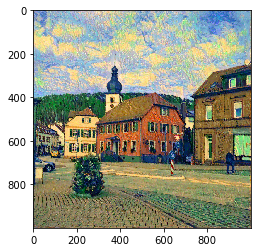

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  5175.3369140625


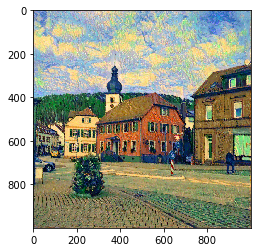

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  5592.75830078125


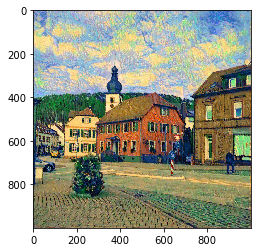

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  4622.80029296875


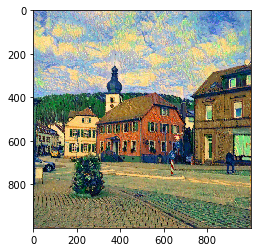

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  4366.72607421875


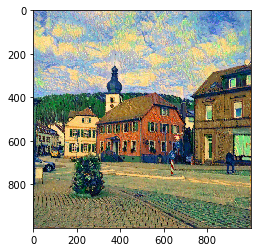

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  4150.51318359375


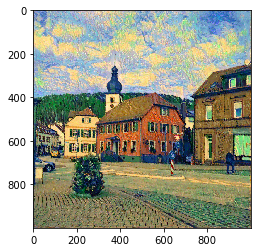

In [44]:
show_every = 500

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        imshow(target)
        plt.show()

In [43]:

#Image.fromarray(target.cpu().detach().numpy().squeeze(0).reshape(1000,1000,3)).save('bal.png')